# Title: Anàlisi del mercat immobiliari a Catalunya (finals 2020)

In [344]:
# Dataset pisos.csv https://www.kaggle.com/datasets/thedevastator/analysis-of-spanish-apartment-pricing-and-size-p (cita: https://zenodo.org/records/4263693)

## 0. Imports

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import textwrap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import pickle

## 1. Load Data

In [346]:
# Load Data
og_df = pd.read_csv('../data/Catalunya/pisos_clean.csv', sep=',')

C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\2781240493.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  og_df = pd.read_csv('../data/Catalunya/pisos_clean.csv', sep=',')


## 2. Data Preparation

In [347]:
df = og_df.copy()

df.head(5)

,summary,location,price,size,rooms,price/m2,bathrooms,Num Photos,type,region
0,Casa en calle Urb. Las Mimosas,Ames (San Tome),250.000 €,315 m²,4,793 €/m²,3,31,pisos,a_coruna
1,Piso en Milladoiro,Ames (San Tome),90.000 €,72 m²,2,1.250 €/m²,1,11,pisos,a_coruna
2,Casa en calle La Piedra,A Ortigueira (Cariño),50.000 €,92 m²,2,543 €/m²,1,40,pisos,a_coruna
3,Casa en Perillo,Perillo (Oleiros),359.000 €,244 m²,4,1.471 €/m²,3,39,pisos,a_coruna
4,Chalet en Urbanización Las Mimosas,O Milladoiro (Ames),200.430 €,315 m²,4,636 €/m²,3,24,pisos,a_coruna


In [348]:
# Drop NaN values
df.dropna(inplace=True)
#df.info()

In [349]:
# Recuperar csv de regions catalanes filtrat manualment
catalan_regions = pd.read_csv('../data/Catalunya/catalan_regions.csv')
catalan_regions_list = list(catalan_regions['0'])
catalan_regions_list

# Filtrar per regions catalanes
df_cat = df[df['region'].isin(catalan_regions_list)]
#df_cat

In [350]:
# Drop locations with less than 10 ocurrences
df_cat = df_cat.groupby('location').filter(lambda x: len(x) > 10)

In [351]:
# Data Cleaning
df_cat.drop(columns=['summary', 'Num Photos'], inplace=True)

# -- Price -- #
df_cat['price'] = df_cat['price'].str.replace(' €', '')
df_cat['price'] = df_cat['price'].str.replace('.', '')
df_cat['price'] = pd.to_numeric(df_cat['price'], errors='coerce')
df_cat = df_cat.dropna(subset=['price'])
df_cat['price'] = df_cat['price'].astype(int)

# -- Size -- #
df_cat['size'] = df_cat['size'].str.replace(' m²', '')
df_cat['size'] = pd.to_numeric(df_cat['size'], errors='coerce')
df_cat = df_cat.dropna(subset=['size'])
df_cat['size'] = df_cat['size'].astype(int)

# -- Price/m2 -- #
df_cat['price/m2'] = df_cat['price'] / df_cat['size']
df_cat['price/m2'] = df_cat['price/m2'].astype(float)
df_cat['price/m2'] = df_cat['price/m2'].round(2)

# -- Type -- #
df_cat['type'] = df_cat['type'].astype(str)
df_cat['type'] = df_cat['type'].replace('piso', 'pisos') # Ajuntem "pisos" i "piso" ja que entenc que son el mateix
df_cat['type'] = df_cat['type'].str.capitalize()
df_cat['type'] = df_cat['type'].str.rstrip('s')

# -- Other vars -- #
df_cat['location'] = df_cat['location'].astype(str)
df_cat['rooms'] = df_cat['rooms'].astype(int)
df_cat['bathrooms'] = df_cat['bathrooms'].astype(int)
df_cat['region'] = df_cat['region'].astype(str)

In [352]:
# Eliminar files duplicades del dataset (si totes les columnes son iguals excepte region)
df_cat = df_cat.drop_duplicates(subset=['location', 'price', 'size', 'rooms', 'bathrooms', 'type'], keep='first')

# Aquesta neteja es deu a que hem trobat moltes entrades duplicades amb regions diferents


In [353]:
# Ordenar alfabeticament per location
df_cat = df_cat.sort_values(by='location').reset_index(drop=True)

## 3. Exploratory Data Analysis (+outlier cleaning)

### 3.1. Basic Information

In [354]:
df_cat.head(5)

,location,price,size,rooms,price/m2,bathrooms,type,region
0,Abrera,352000,180,3,1955.56,3,Casa,barcelona
1,Abrera,289000,223,5,1295.96,3,Piso,baix_llobregat_nord
2,Abrera,453200,413,5,1097.34,4,Piso,baix_llobregat_nord
3,Abrera,180000,73,3,2465.75,1,Piso,baix_llobregat_nord
4,Abrera,549000,336,5,1633.93,4,Piso,baix_llobregat_nord


In [355]:
# 1. Basic DataFrame Information
print("DataFrame Shape:", df_cat.shape)
print("---------------------------------")
print("DataFrame Info:")
df_cat.info()

# 2. Missing Values Analysis
print("---------------------------------")
print("Missing Values:")
print(df_cat.isnull().sum())
missing_percentages = (df_cat.isnull().sum() / len(df_cat)) * 100
print("Missing Values (%):")
print(missing_percentages)

# 3. Statistical Summary
print("---------------------------------")
print("Numerical Columns Summary:")
print(df_cat.describe())

# 4. Unique Values in Each Column
print("---------------------------------")
print("Unique Values Count:")
for column in df_cat.columns:
    print(f"{column}: {df_cat[column].nunique()}")

DataFrame Shape: (66456, 8)
---------------------------------
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66456 entries, 0 to 66455
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   location   66456 non-null  object 
 1   price      66456 non-null  int32  
 2   size       66456 non-null  int32  
 3   rooms      66456 non-null  int32  
 4   price/m2   66456 non-null  float64
 5   bathrooms  66456 non-null  int32  
 6   type       66456 non-null  object 
 7   region     66456 non-null  object 
dtypes: float64(1), int32(4), object(3)
memory usage: 3.0+ MB
---------------------------------
Missing Values:
location     0
price        0
size         0
rooms        0
price/m2     0
bathrooms    0
type         0
region       0
dtype: int64
Missing Values (%):
location     0.0
price        0.0
size         0.0
rooms        0.0
price/m2     0.0
bathrooms    0.0
type         0.0
region       0.0
dtype: float6

### 3.2 Anàlisi de les variables numèriques

In [356]:
# Eliminar el "outlier padre" (100 i algo banys i habitacions)
df_cat = df_cat[df_cat['bathrooms'] < 30]
df_cat = df_cat[df_cat['rooms'] < 40]

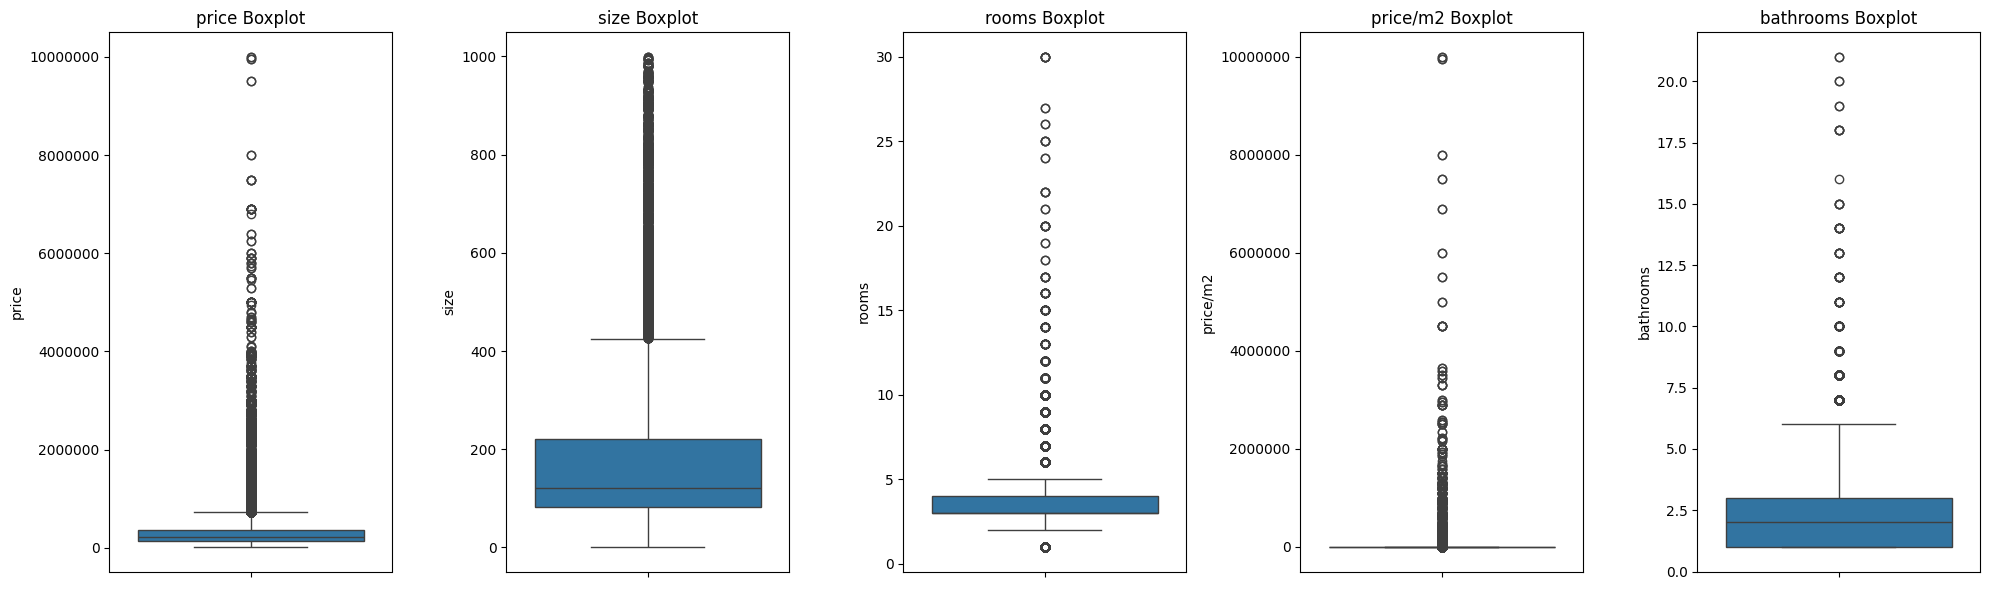

In [357]:
numeric_cols = df_cat.select_dtypes(include=['int32', 'float64']).columns

# Boxplots inicials de les variables numèriques
fig, ax = plt.subplots(1, 5, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=df_cat, ax=ax[i])
    ax[i].set_title(f'{col} Boxplot')
    ax[i].ticklabel_format(style='plain', axis='y')
    ax[i].set_ylabel(col)
    ax[i].set_xlabel('')
plt.tight_layout()
plt.show()

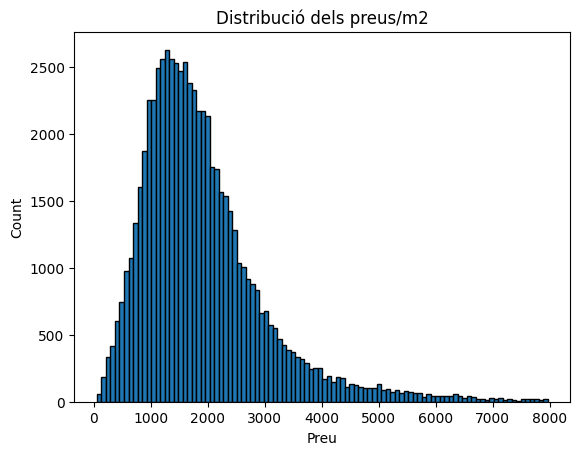

In [358]:
# Eliminar outliers de preus/m2 (eliminat previa comprovació de l'histograma)
df_cat = df_cat[df_cat['price/m2'] < 8000]
df_cat = df_cat[df_cat['price/m2'] > 50]

# Histograma preu per m2
preus_m2 = df_cat['price/m2']
plt.hist(preus_m2, bins=100, edgecolor='black')
plt.title('Distribució dels preus/m2')
plt.xlabel('Preu')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

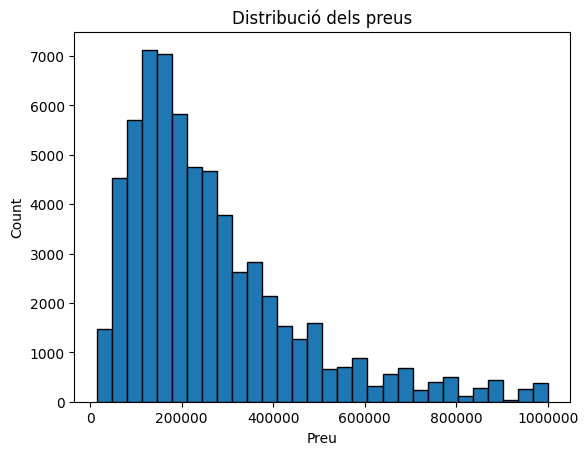

In [359]:
# Treiem les vivendes de +1M € (l'estudi i predicció es centrarà en pisos de preu més assequible)
df_cat = df_cat[df_cat['price'] <= 1000000]

# Histograma dels preus
preus = df_cat['price']
plt.hist(preus, bins=30, edgecolor='black')
plt.title('Distribució dels preus')
plt.xlabel('Preu')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


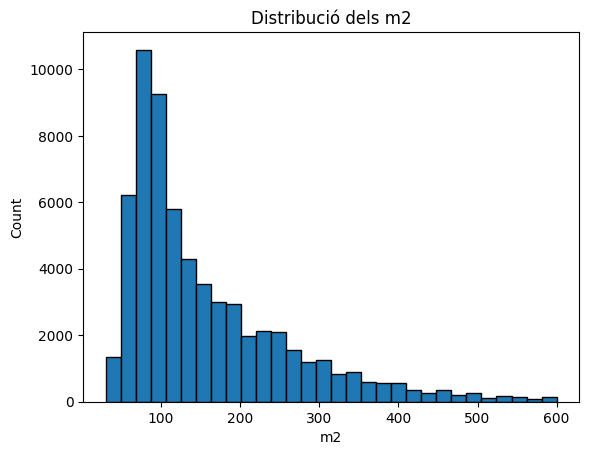

In [360]:
# Treiem les vivendes de +600m2 i -30m2 (entenem que son outliers)
df_cat = df_cat[df_cat['size'] <= 600]
df_cat = df_cat[df_cat['size'] >= 30]

# Histograma dels m2
size = df_cat['size']
plt.hist(size, bins=30, edgecolor='black')
plt.title('Distribució dels m2')
plt.xlabel('m2')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

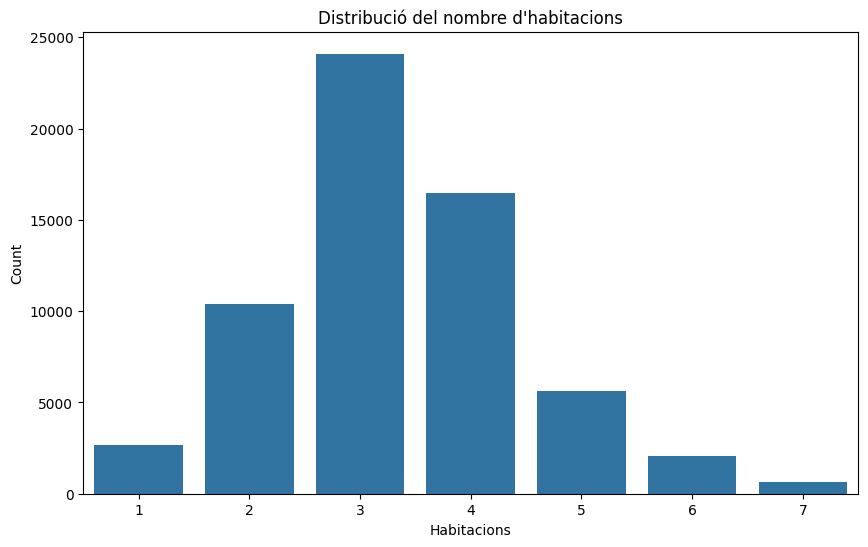

In [361]:
# Treiem els outliers amb mes de 7 habitacions (mateixa raó que amb el preu i m2)
df_cat = df_cat[df_cat['rooms'] <= 7]

# Barplot de les habitacions
rooms = df_cat['rooms'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=rooms.index, y=rooms.values)
plt.title('Distribució del nombre d\'habitacions')
plt.xlabel('Habitacions')
plt.ylabel('Count')
plt.show()

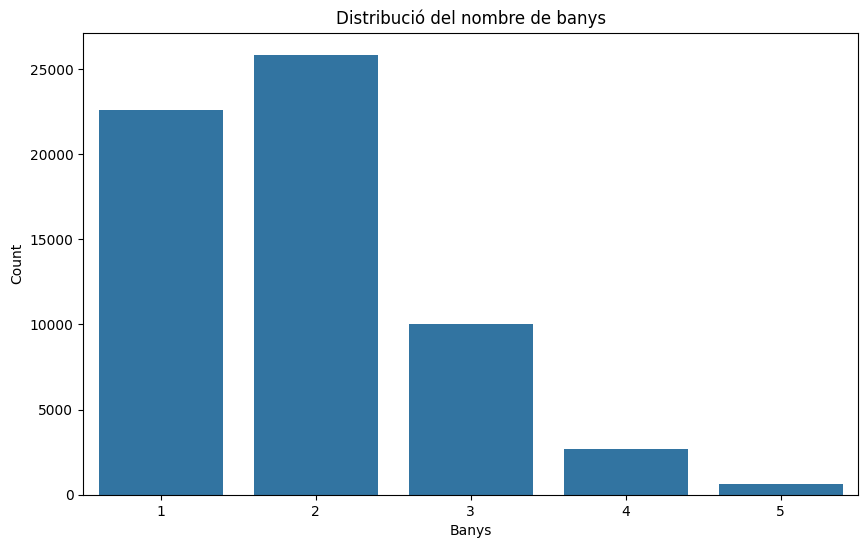

In [362]:
# Treiem els outliers amb mes de 5 banys
df_cat = df_cat[df_cat['bathrooms'] <= 5]

# Barplot dels banys
bathrooms = df_cat['bathrooms'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=bathrooms.index, y=bathrooms.values)
plt.title('Distribució del nombre de banys')
plt.xlabel('Banys')
plt.ylabel('Count')
plt.show()

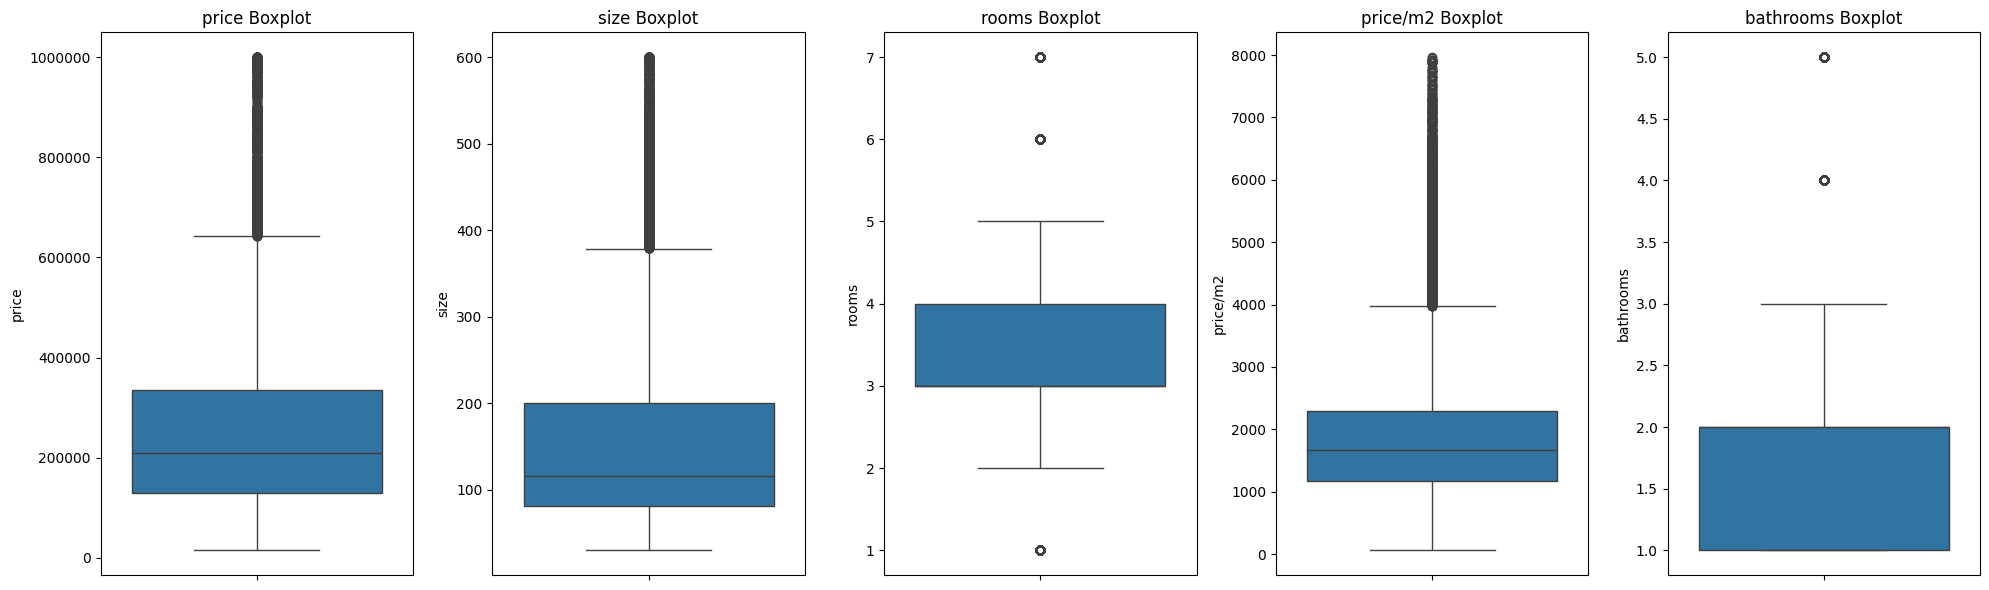

In [363]:
# Boxplots despres de netejar outliers
fig, ax = plt.subplots(1, 5, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=df_cat, ax=ax[i])
    ax[i].set_title(f'{col} Boxplot')
    ax[i].ticklabel_format(style='plain', axis='y')
    ax[i].set_ylabel(col)
    ax[i].set_xlabel('')
plt.tight_layout()
plt.show()

### 3.3 Anàlisi de les variables categòriques

C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\1772152385.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[0].get_yticklabels()])
C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\1772152385.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[1].get_yticklabels()])


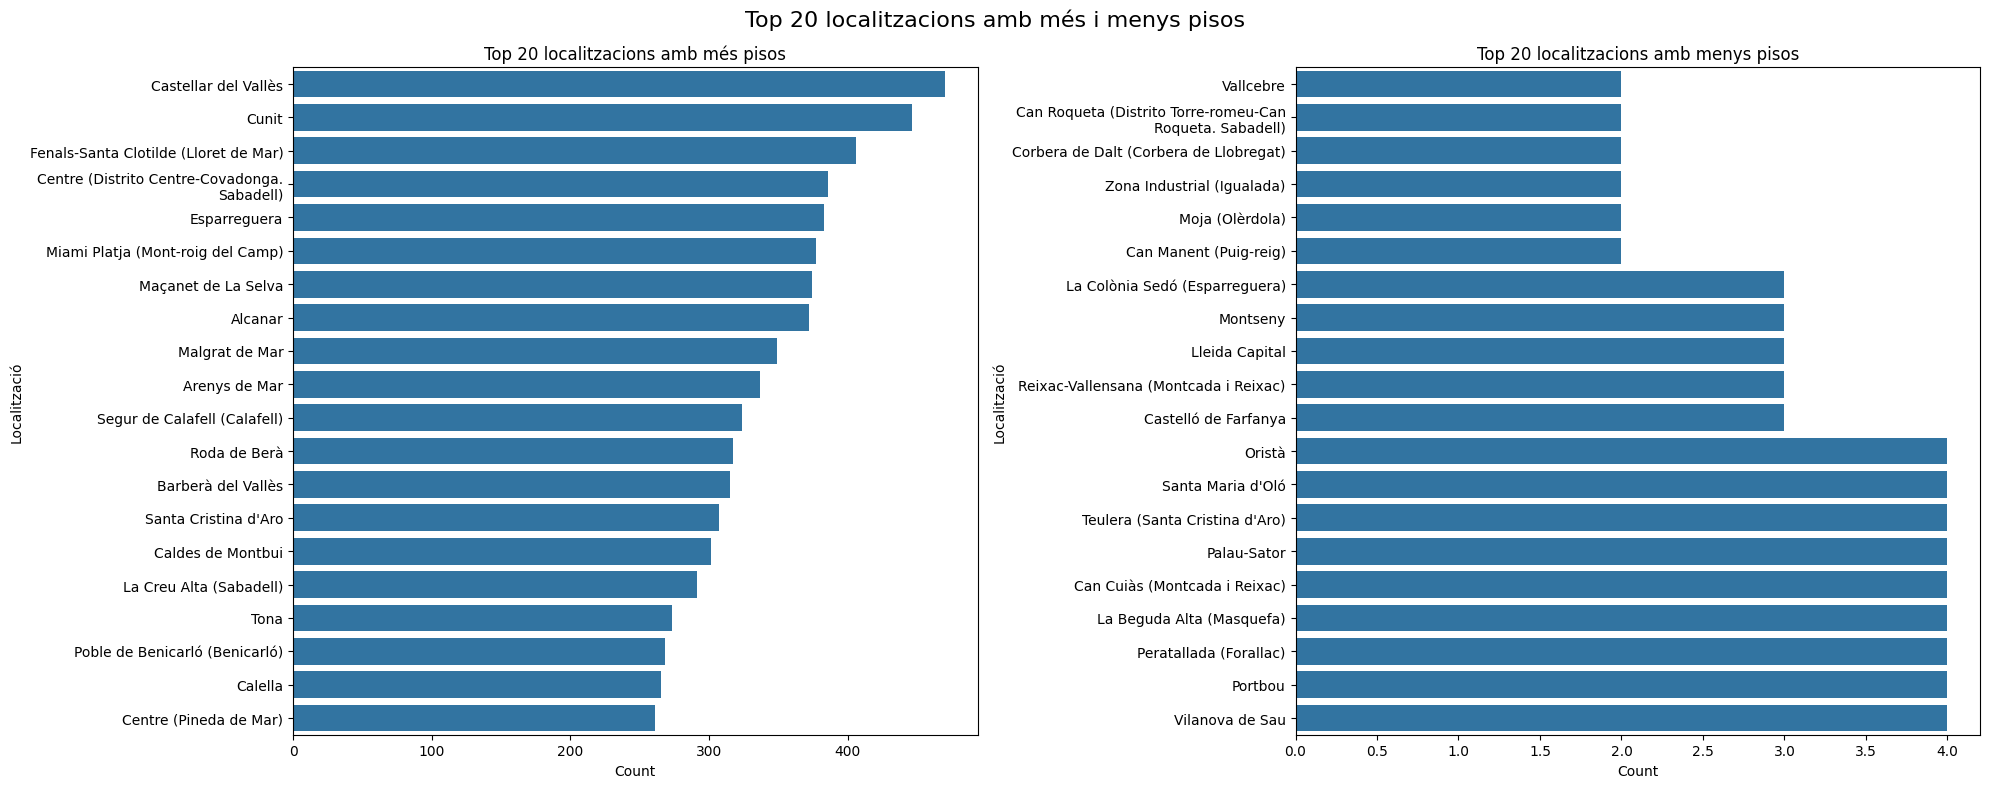

61788


In [364]:
# Barplot de top 20 localitzacions amb més i menys pisos
top_20_locations = df_cat['location'].value_counts().head(20)
bottom_20_locations = df_cat['location'].value_counts().tail(20).sort_values(ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Top 20 localitzacions amb més i menys pisos', fontsize=16)
sns.barplot(x=top_20_locations.values, y=top_20_locations.index, ax=ax[0])
ax[0].set_title('Top 20 localitzacions amb més pisos')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Localització')
ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[0].get_yticklabels()])
sns.barplot(x=bottom_20_locations.values, y=bottom_20_locations.index, ax=ax[1])
ax[1].set_title('Top 20 localitzacions amb menys pisos')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Localització')
ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[1].get_yticklabels()])
plt.tight_layout()
plt.show()

# Netejem les localitzacions amb menys de 10 entrades
print(len(df_cat))
df_cat = df_cat.groupby('location').filter(lambda x: len(x) >= 10)

C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\991628920.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[0].get_yticklabels()])
C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\991628920.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[1].get_yticklabels()])


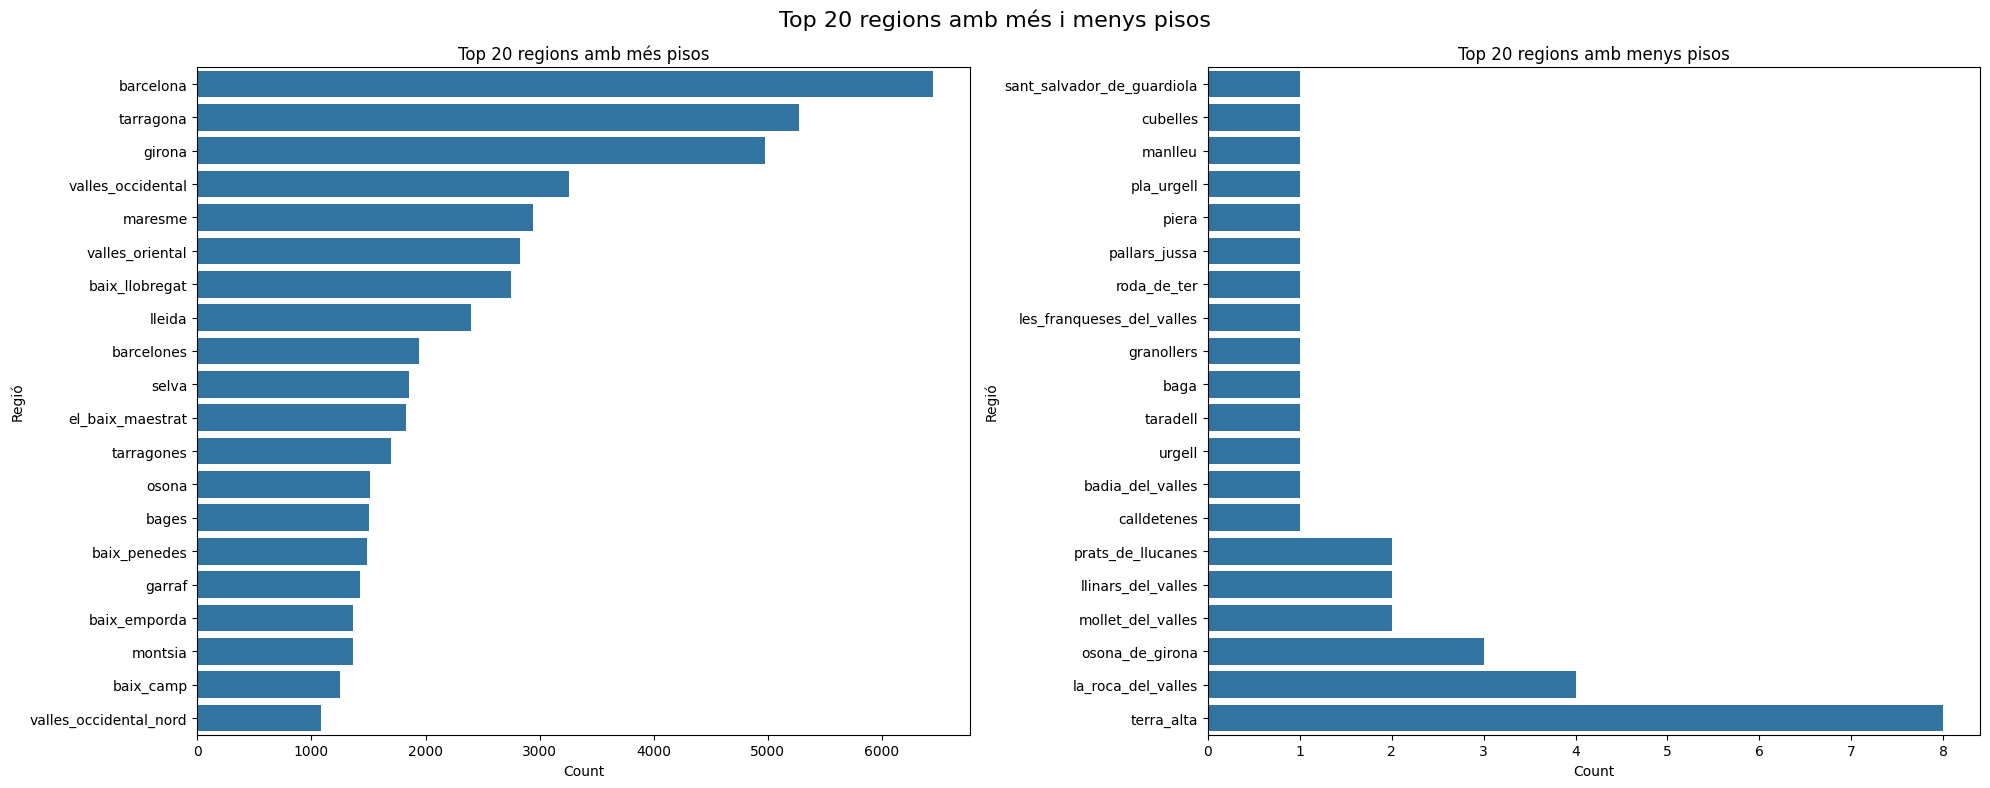

60702


In [365]:
# Barplot de top 20 regions amb més i menys pisos
top_20_regions = df_cat['region'].value_counts().head(20)
bottom_20_regions = df_cat['region'].value_counts().tail(20).sort_values(ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Top 20 regions amb més i menys pisos', fontsize=16)
sns.barplot(x=top_20_regions.values, y=top_20_regions.index, ax=ax[0])
ax[0].set_title('Top 20 regions amb més pisos')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Regió')
ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[0].get_yticklabels()])
sns.barplot(x=bottom_20_regions.values, y=bottom_20_regions.index, ax=ax[1])
ax[1].set_title('Top 20 regions amb menys pisos')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Regió')
ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[1].get_yticklabels()])
plt.tight_layout()
plt.show()

# Netejem les regions amb menys de 5 entrades
print(len(df_cat))
df_cat = df_cat.groupby('region').filter(lambda x: len(x) >= 5)


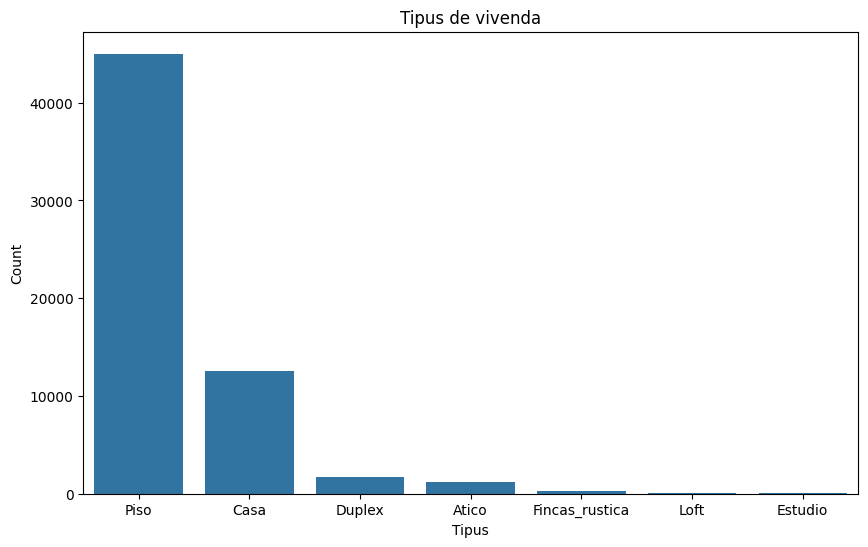

In [366]:
# Tipus de vivenda
tipus = df_cat['type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=tipus.index, y=tipus.values)
plt.title('Tipus de vivenda')
plt.xlabel('Tipus')
plt.ylabel('Count')
plt.show()

# 215 finques rustiques, suficient

# Eliminem lofts i estudis
df_cat = df_cat[df_cat['type'] != 'Loft']
df_cat = df_cat[df_cat['type'] != 'Estudio']

### 3.4 Altres anàlisis interessants

C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\2551333495.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=50) for label in ax[0].get_yticklabels()])
C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\2551333495.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=50) for label in ax[1].get_yticklabels()])


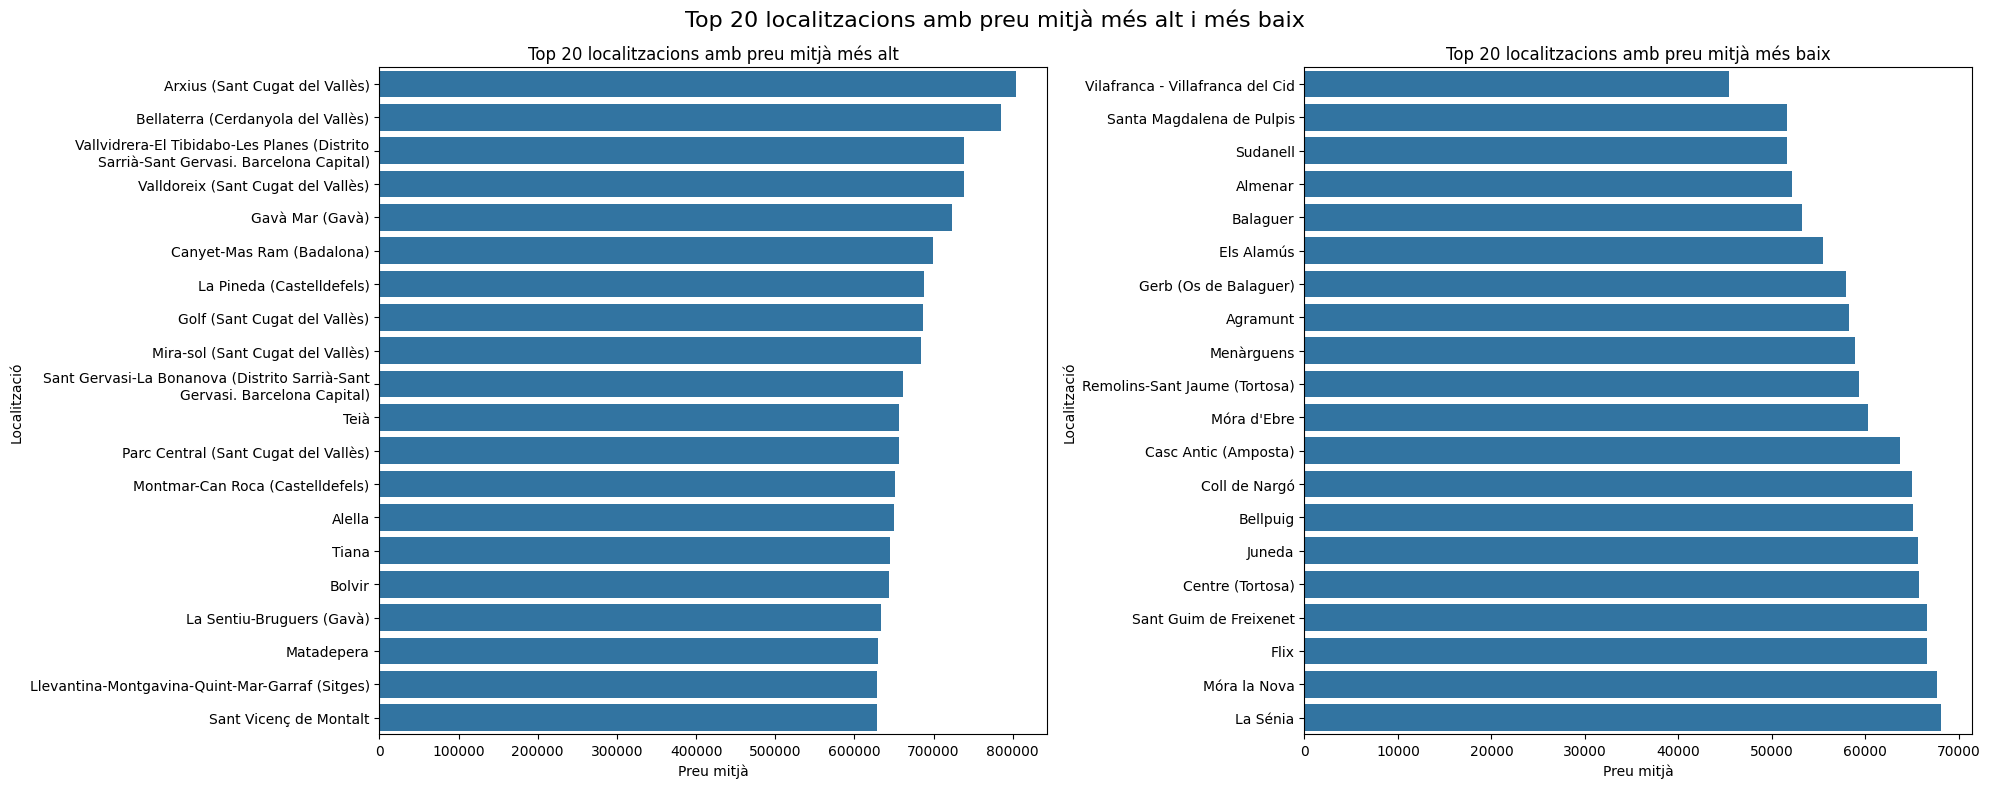

In [367]:
# LOCALITZACIONS amb el preu mitjà més alt i més baix
top_locations_prices_high = df_cat.groupby('location')['price'].mean().sort_values(ascending=False).head(20)
top_locations_prices_low = df_cat.groupby('location')['price'].mean().sort_values(ascending=True).head(20)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Top 20 localitzacions amb preu mitjà més alt i més baix', fontsize=16)
sns.barplot(x=top_locations_prices_high.values, y=top_locations_prices_high.index, ax=ax[0])
ax[0].set_title('Top 20 localitzacions amb preu mitjà més alt')
ax[0].set_xlabel('Preu mitjà')
ax[0].set_ylabel('Localització')
ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=50) for label in ax[0].get_yticklabels()])
sns.barplot(x=top_locations_prices_low.values, y=top_locations_prices_low.index, ax=ax[1])
ax[1].set_title('Top 20 localitzacions amb preu mitjà més baix')
ax[1].set_xlabel('Preu mitjà')
ax[1].set_ylabel('Localització')
ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=50) for label in ax[1].get_yticklabels()])
plt.tight_layout()
plt.show()

C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\545826283.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=50) for label in ax[0].get_yticklabels()])
C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\545826283.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=50) for label in ax[1].get_yticklabels()])


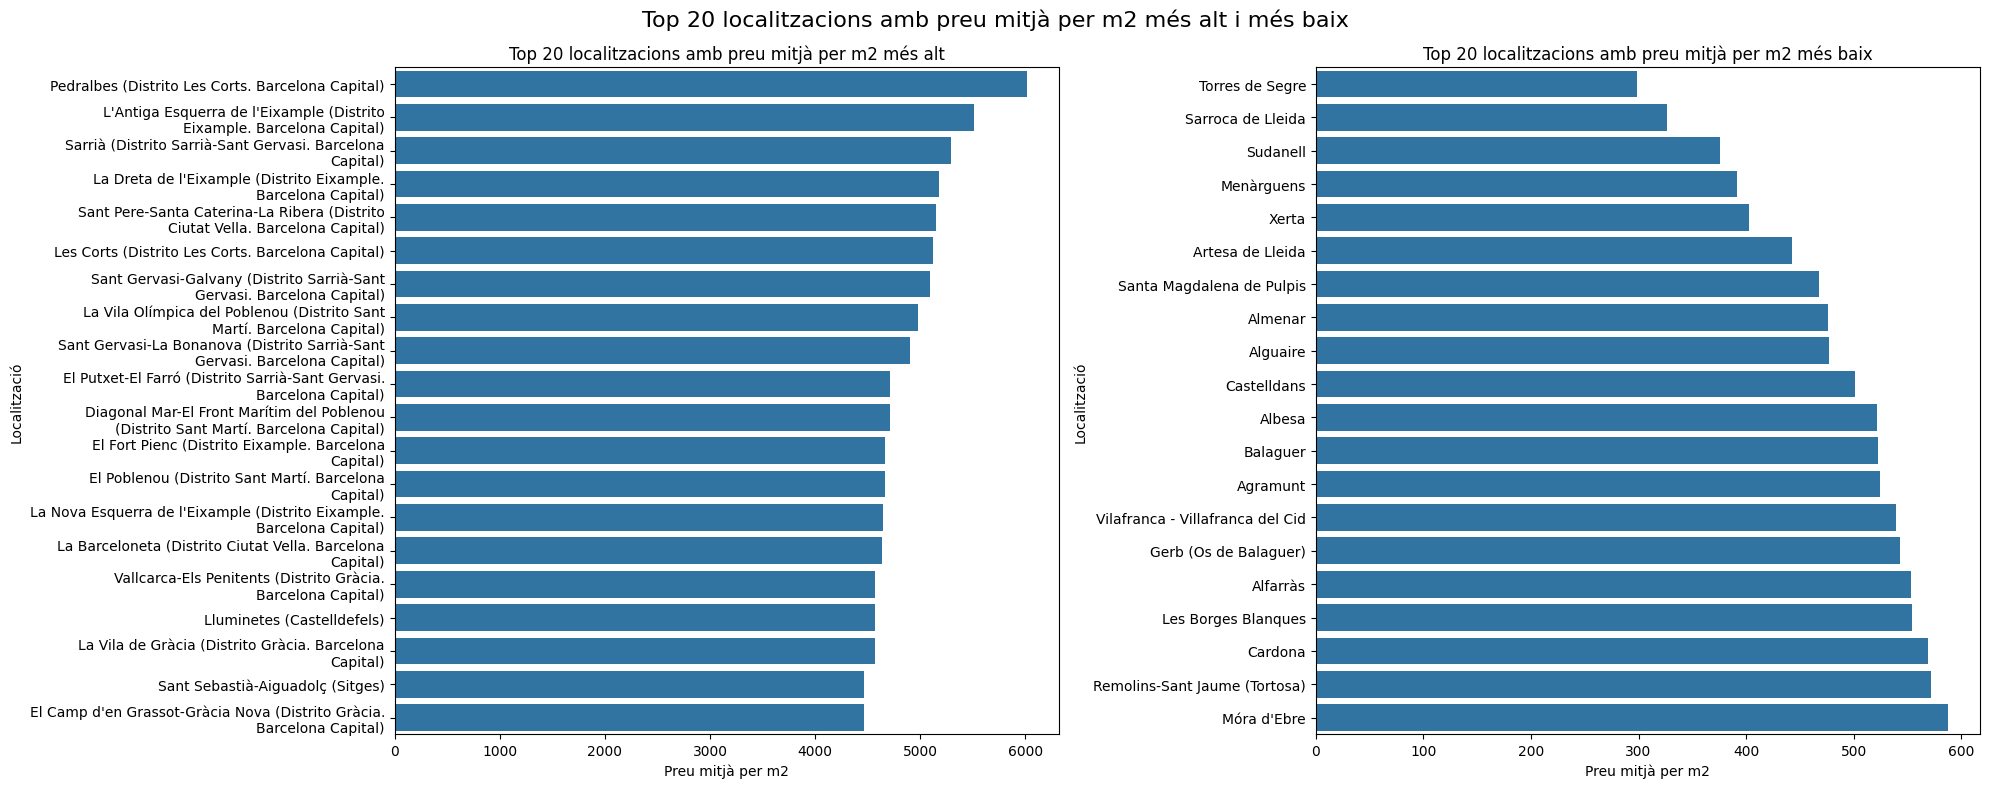

In [368]:
# LOCALITZACIONS amb el preu mitjà per m2 més alt i més baix
top_locations_prices_m2_high = df_cat.groupby('location')['price/m2'].mean().sort_values(ascending=False).head(20)
top_locations_prices_m2_low = df_cat.groupby('location')['price/m2'].mean().sort_values(ascending=True).head(20)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Top 20 localitzacions amb preu mitjà per m2 més alt i més baix', fontsize=16)
sns.barplot(x=top_locations_prices_m2_high.values, y=top_locations_prices_m2_high.index, ax=ax[0])
ax[0].set_title('Top 20 localitzacions amb preu mitjà per m2 més alt')
ax[0].set_xlabel('Preu mitjà per m2')
ax[0].set_ylabel('Localització')
ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=50) for label in ax[0].get_yticklabels()])
sns.barplot(x=top_locations_prices_m2_low.values, y=top_locations_prices_m2_low.index, ax=ax[1])
ax[1].set_title('Top 20 localitzacions amb preu mitjà per m2 més baix')
ax[1].set_xlabel('Preu mitjà per m2')
ax[1].set_ylabel('Localització')
ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=50) for label in ax[1].get_yticklabels()])
plt.tight_layout()
plt.show()

C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\3075984738.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[0].get_yticklabels()])
C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\3075984738.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[1].get_yticklabels()])


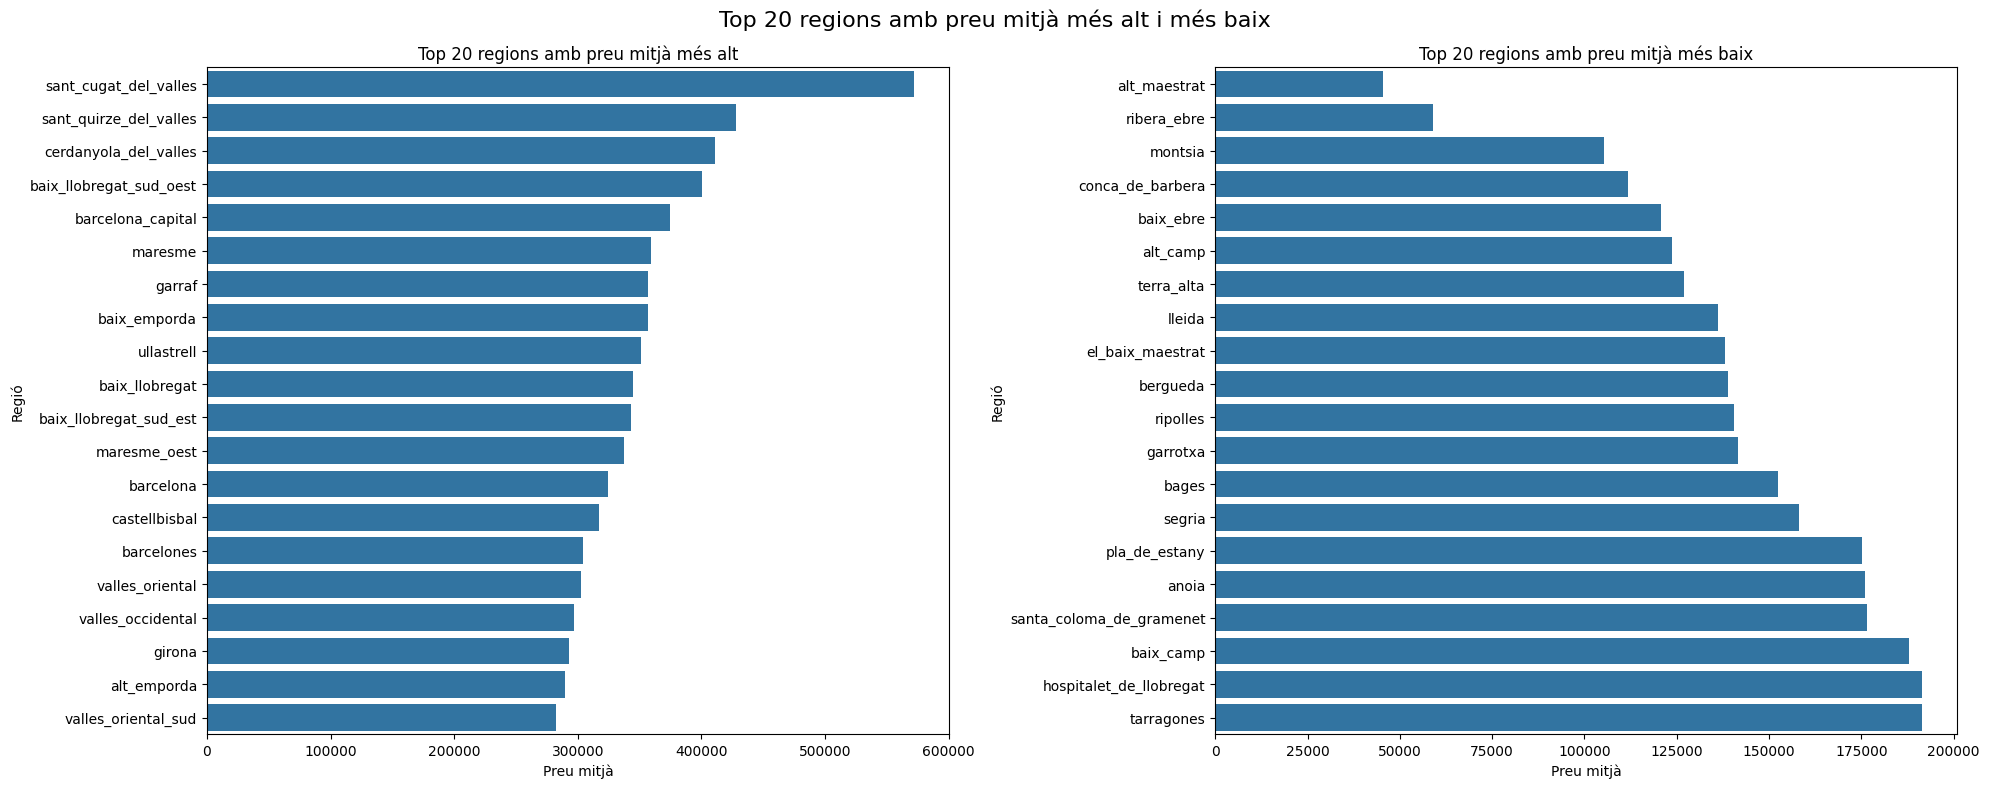

In [369]:
# REGIONS amb el preu mitjà més alt i més baix
top_regions_prices_high = df_cat.groupby('region')['price'].mean().sort_values(ascending=False).head(20)
top_regions_prices_low = df_cat.groupby('region')['price'].mean().sort_values(ascending=True).head(20)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Top 20 regions amb preu mitjà més alt i més baix', fontsize=16)
sns.barplot(x=top_regions_prices_high.values, y=top_regions_prices_high.index, ax=ax[0])
ax[0].set_title('Top 20 regions amb preu mitjà més alt')
ax[0].set_xlabel('Preu mitjà')
ax[0].set_ylabel('Regió')
ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[0].get_yticklabels()])
sns.barplot(x=top_regions_prices_low.values, y=top_regions_prices_low.index, ax=ax[1])
ax[1].set_title('Top 20 regions amb preu mitjà més baix')
ax[1].set_xlabel('Preu mitjà')
ax[1].set_ylabel('Regió')
ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[1].get_yticklabels()])
plt.tight_layout()
plt.show()

C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\1665577725.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[0].get_yticklabels()])
C:\Users\pdpau\AppData\Local\Temp\ipykernel_14512\1665577725.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[1].get_yticklabels()])


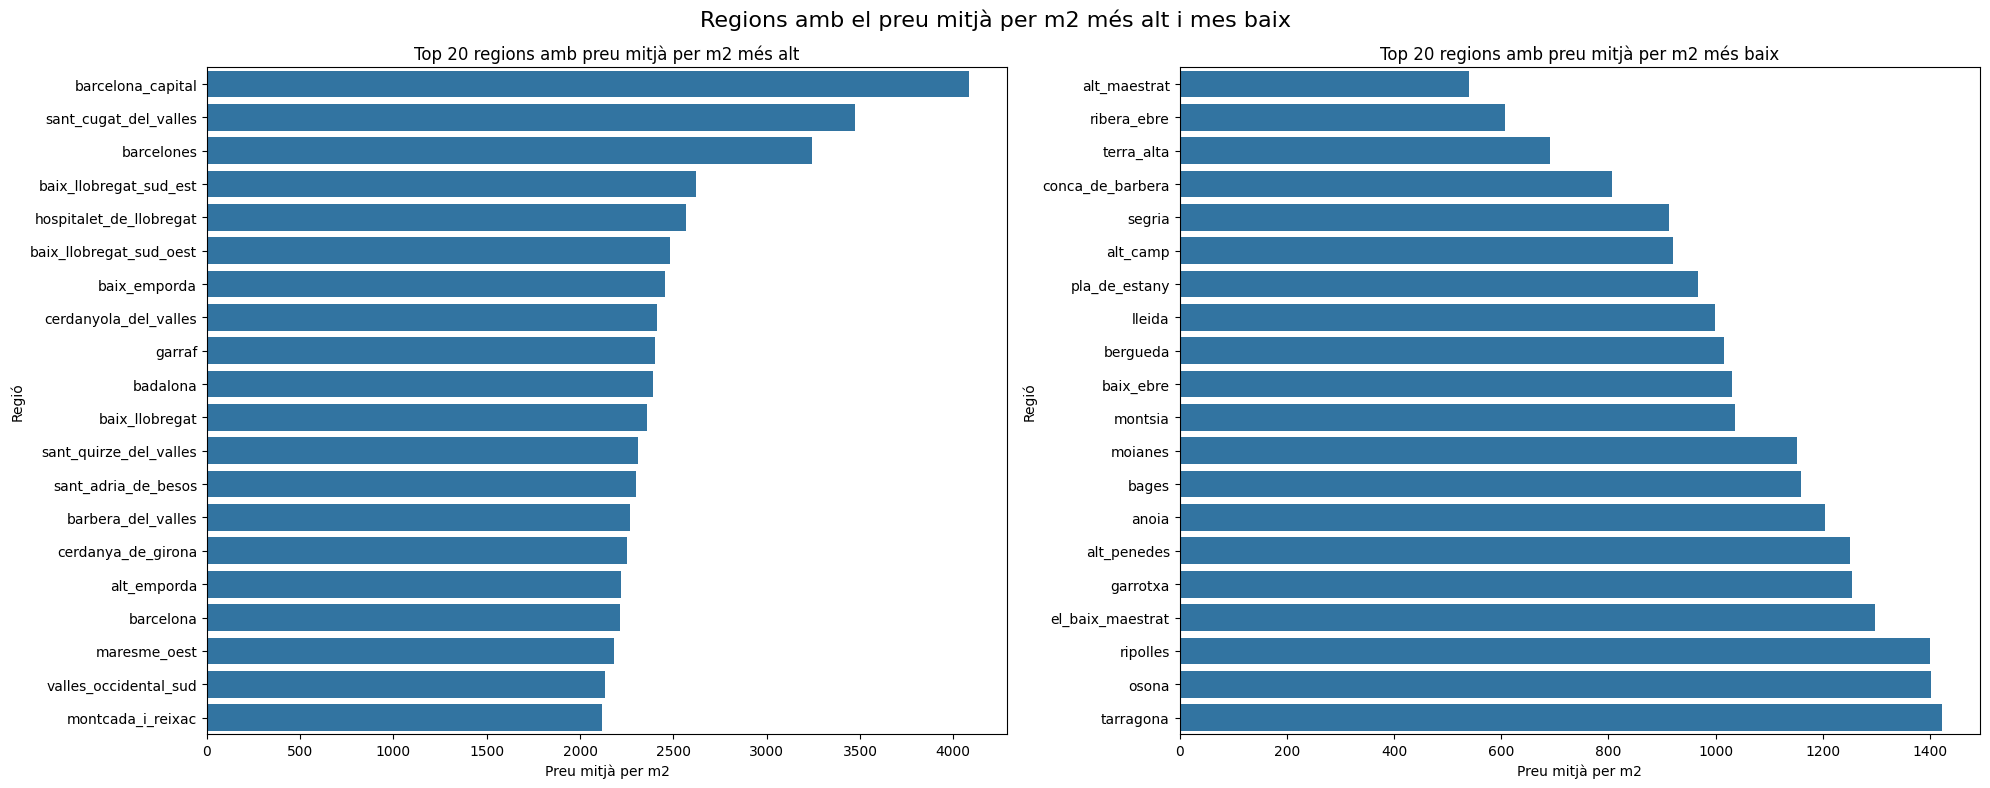

In [370]:
# REGIONS amb el preu mitjà per m2 més alt i mes baix
top_regions_prices_m2_high = df_cat.groupby('region')['price/m2'].mean().sort_values(ascending=False).head(20)
top_regions_prices_m2_low = df_cat.groupby('region')['price/m2'].mean().sort_values(ascending=True).head(20)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Regions amb el preu mitjà per m2 més alt i mes baix', fontsize=16)
sns.barplot(x=top_regions_prices_m2_high.values, y=top_regions_prices_m2_high.index, ax=ax[0])
ax[0].set_title('Top 20 regions amb preu mitjà per m2 més alt')
ax[0].set_xlabel('Preu mitjà per m2')
ax[0].set_ylabel('Regió')
ax[0].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[0].get_yticklabels()])
sns.barplot(x=top_regions_prices_m2_low.values, y=top_regions_prices_m2_low.index, ax=ax[1])
ax[1].set_title('Top 20 regions amb preu mitjà per m2 més baix')
ax[1].set_xlabel('Preu mitjà per m2')
ax[1].set_ylabel('Regió')
ax[1].set_yticklabels([textwrap.fill(label.get_text(), width=40) for label in ax[1].get_yticklabels()])
plt.tight_layout()
plt.show()

### Correlation Matrix de les variables numèriques

Text(0.5, 1.0, 'Correlation Matrix')

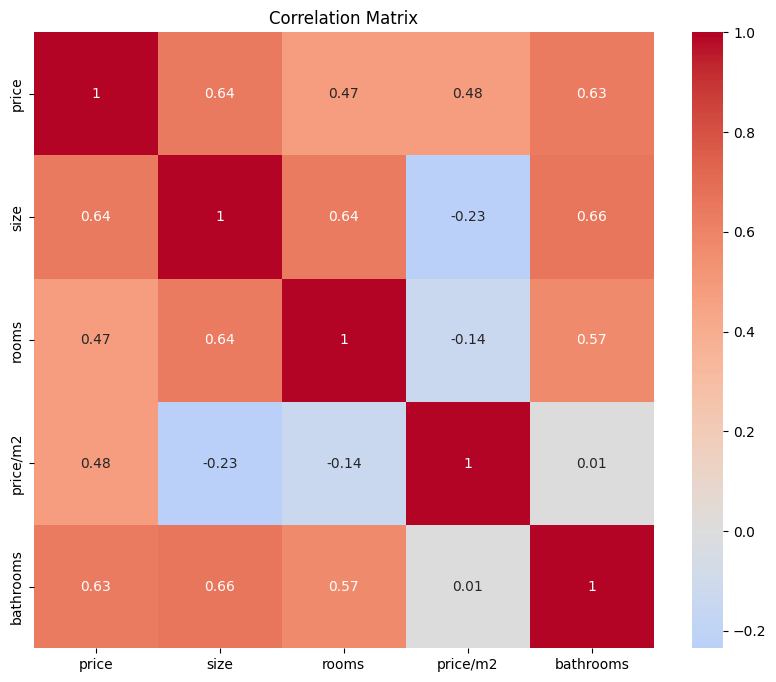

In [371]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_cat.select_dtypes(include=['float64', 'int32']).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

# Curiós que el numero de banys estigui mes correlacionat amb el preu que els m2

## 4. Model

In [372]:
# Guardar dataset preparat per entreanr el model
#df_cat.drop(columns=['price/m2'], inplace=True)
df_cat.to_csv('../data/Catalunya/pisos_catalunya_net_model.csv', index=False)

In [373]:
model_df = pd.read_csv('../data/Catalunya/pisos_catalunya_net_model.csv', sep=',')
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60542 entries, 0 to 60541
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   location   60542 non-null  object 
 1   price      60542 non-null  int64  
 2   size       60542 non-null  int64  
 3   rooms      60542 non-null  int64  
 4   price/m2   60542 non-null  float64
 5   bathrooms  60542 non-null  int64  
 6   type       60542 non-null  object 
 7   region     60542 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 3.7+ MB


In [374]:
# LABEL ENCODING

le_location = LabelEncoder()
le_type = LabelEncoder()

le_region = LabelEncoder()

model_df['location'] = le_location.fit_transform(model_df['location'])
model_df['type'] = le_type.fit_transform(model_df['type'])
#model_df['region'] = le_region.fit_transform(model_df['region'])

In [375]:
# TRAIN TEST SPLIT

# Al final no utilitzarem la regió per entrenar el model ja que abarca massa territori i conté errors
X = model_df.drop(columns=['price', 'price/m2', 'region']) # Features
y = model_df['price'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(45406, 15136, 45406, 15136)

In [376]:
# MODEL TRAINING

model = RandomForestRegressor(n_estimators=500, random_state=42) # TODO: Revisar que sigui el model adequat
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [377]:
# Exportem model i label encoders

path_model = "../web/pkl_files/model_catalunya.pkl"
path_le_location = "../web/pkl_files/le_location_catalunya.pkl"
path_le_type = "../web/pkl_files/le_type_catalunya.pkl"

with open(path_model, 'wb') as file:
    pickle.dump(model, file)
print(f"Model saved at {path_model}")

with open(path_le_location, 'wb') as file:
    pickle.dump(le_location, file)
print(f"Label Encoder Location saved at {path_le_location}")

with open(path_le_type, 'wb') as file:
    pickle.dump(le_type, file)
print(f"Label Encoder Type saved at {path_le_type}")


Model saved at ../web/pkl_files/model_catalunya.pkl
Label Encoder Location saved at ../web/pkl_files/le_location_catalunya.pkl
Label Encoder Type saved at ../web/pkl_files/le_type_catalunya.pkl


## 5. Evaluation

In [378]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Squared Error: 8093491651.888209
Mean Absolute Error: 59059.452091021216
R2 Score: 0.7602287772916877


In [379]:
# TODO: Test predicció amb dades input usuari


## 6. Explainability